In [1]:
import torch 
from torch import nn
import pandas as pd
import numpy as np
import torch.nn.functional as F

In [2]:
df = pd.read_csv('../data/titanic/train.csv')
df1 = pd.read_csv('../data/titanic/test.csv')
x = df.dtypes[df.dtypes!='object'].index
len(df.dtypes)

12

In [3]:
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [4]:
df1['Ticket'].apply(lambda x:x[:1])

0      3
1      3
2      2
3      3
4      3
      ..
413    A
414    P
415    S
416    3
417    2
Name: Ticket, Length: 418, dtype: object

In [5]:
df.loc[:4]
len(df)

891

In [6]:
from kaggle_utils import Dataset


class TitanicData(Dataset):
    def __init__(self, batch_size) -> None:
        id_col, label, name, tiket, cabin = 'PassengerId', 'Survived', 'Name', 'Ticket', 'Cabin'
        self.raw_train_df = pd.read_csv('../data/titanic/train.csv')
        self.raw_val_df = pd.read_csv('../data/titanic/test.csv')
        self.batch_size = batch_size
        self.train_drop_df = self.raw_train_df.drop(
            columns=[id_col, label, name, tiket, cabin])
        self.val_drop_df = self.raw_val_df.drop(
            columns=[id_col, name, tiket, cabin])
        self.label_df = self.raw_train_df[label]
        self.preprocess()

    def preprocess(self):
        features = pd.concat((self.train_drop_df, self.val_drop_df))
        # numeric_cols = self.train_drop_df.dtypes[self.train_drop_df.dtypes != 'object'].index
        # features[numeric_cols] = features[numeric_cols].apply(
        #     lambda x: (x-x.mean())/x.std())
        # features[numeric_cols].fillna(
        #     features[numeric_cols].mean(), inplace=True)
        # features['Age'] = features['Age'].fillna(
        #     features['Age'].mean(), inplace=True)
        features["Age"].fillna(features["Age"].mean(), inplace=True)
        features["Fare"].fillna(features["Fare"].mean(), inplace=True)
        features[["Age", "Fare"]] = features[["Age", "Fare"]].apply(lambda x: (x-x.mean())/x.std())
        features = pd.get_dummies(features, dummy_na=True)
        # save data for train/valdiate
        self.train = features.iloc[:len(self.train_drop_df)].copy()
        self.label = self.label_df.copy()
        self.test = features.iloc[len(self.train_drop_df):]
        self.val = None

    def get_dataloader(self, train=True):
        size = len(self.train_drop_df)
        num_train = size-size//5
        datasets = self.train.iloc[:num_train] if train else self.train.iloc[num_train:]
        labels = self.label.iloc[:num_train] if train else self.label.iloc[num_train:]
        d_tensor = torch.tensor(datasets.values, dtype=torch.float32)
        l_tensor = torch.tensor(labels.values)
        ds = torch.utils.data.TensorDataset(d_tensor, l_tensor)
        return torch.utils.data.DataLoader(ds, batch_size=self.batch_size, shuffle=train)

In [7]:
data = TitanicData(32)
# data.train.to_csv('submission.csv', index=False)
data.train[:4]

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Sex_nan,Embarked_C,Embarked_Q,Embarked_S,Embarked_nan
0,3,-0.611738,1,0,-0.503402,0,1,0,0,0,1,0
1,1,0.630190,1,0,0.734222,1,0,0,1,0,0,0
2,3,-0.301256,0,0,-0.490356,1,0,0,0,0,1,0
3,1,0.397329,1,0,0.382778,1,0,0,0,0,1,0


In [8]:
len(data.train.dtypes)

12

In [9]:
from kaggle_utils import Classifier


class TitanicClassifier(Classifier):
    def __init__(self, input_dims, output_dims, lr=0.001):
        super().__init__(input_dims, output_dims, lr)
        self.lr = lr
        self.net = nn.Sequential(
            # nn.LayerNorm(input_dims),
            nn.LazyLinear(16),
            nn.ReLU(),
            # nn.Dropout(0.15),
            nn.LazyLinear(8),
            nn.ReLU(),
            # nn.Dropout(0.15),
            nn.LazyLinear(output_dims),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        res =  self.net(x)
        # print(res)
        return res

In [10]:
from kaggle_utils import Trainer
data = TitanicData(32)
model = TitanicClassifier(12, 2)
trainer = Trainer(max_epochs=20)
trainer.fit(model, data)

/Users/tangyun/opt/miniconda3/envs/rl/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


complete 0 epoch train_loss=15.941925287246704 validate_loss=4.108500719070435
complete 1 epoch train_loss=15.63906842470169 validate_loss=4.009192168712616
complete 2 epoch train_loss=15.353150367736816 validate_loss=3.8783063292503357
complete 3 epoch train_loss=14.948957681655884 validate_loss=3.729410946369171
complete 4 epoch train_loss=14.677764534950256 validate_loss=3.5944849252700806
complete 5 epoch train_loss=14.256432712078094 validate_loss=3.4781885743141174
complete 6 epoch train_loss=13.89670878648758 validate_loss=3.328981578350067
complete 7 epoch train_loss=13.258138179779053 validate_loss=3.174247682094574
complete 8 epoch train_loss=12.828835010528564 validate_loss=3.037859559059143
complete 9 epoch train_loss=12.44928553700447 validate_loss=2.9590781927108765
complete 10 epoch train_loss=12.234376162290573 validate_loss=2.9132326245307922
complete 11 epoch train_loss=11.962865352630615 validate_loss=2.8868261873722076
complete 12 epoch train_loss=11.94487589597702 

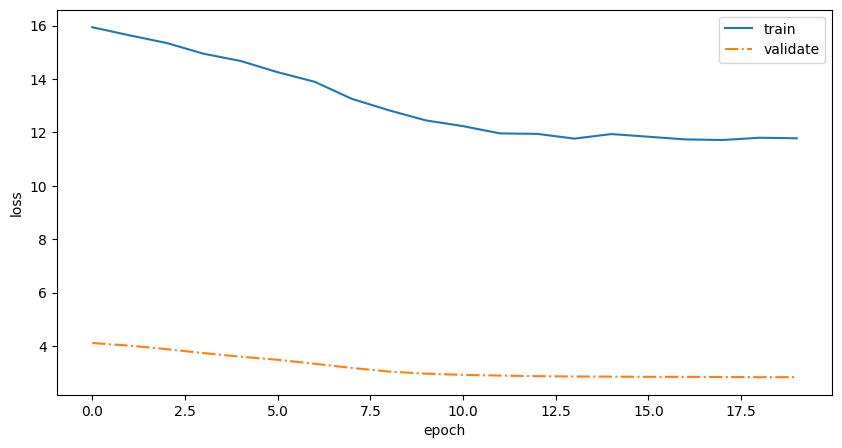

In [11]:
trainer.plot()

In [12]:
pred = model.forward(torch.tensor(data.test.values, dtype=torch.float32))
# pred[150:160]
# pred[150:200].sum(dim=-1, keepdim=True)
m = torch.multinomial(pred, num_samples=1)
# m.detach().numpy()
submission = pd.DataFrame(
    {'PassengerId': data.raw_val_df['PassengerId'], 'Survived': m.view(-1,).detach().numpy()})
submission.to_csv('submission.csv',index=False)